In [62]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor, IsolationForest
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [63]:
df = pd.read_csv("data/final.csv")

In [64]:
df.columns[~df.columns.str.startswith("embedding")]

Index(['Unnamed: 0', 'source', 'domain', 'chart', 'region', 'date', 'position',
       'title', 'artist', 'scraped_at', 'track_name', 'artists', 'album_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre', 'lyrics', 'lyrics_language', 'happiness_from_lyrics',
       'track_id', 'h_track', 'catharsis_score'],
      dtype='object')

In [65]:
df.shape

(1550, 250)

In [ ]:
df = df.drop(columns=['Unnamed: 0', 'position'])
df = df.dropna(subset=["happiness_from_lyrics"])
df["explicit"] = df["explicit"].astype(int)
df = df.dropna(axis=1, how="any")
#rare genres grouped
genre_counts = df["track_genre"].value_counts()
rare_genres = genre_counts[genre_counts < 10].index

df["track_genre_grouped"] = df["track_genre"].where(
    ~df["track_genre"].isin(rare_genres),
    other="Other"
)
#rare languages grouped
lang_counts = df["lyrics_language"].value_counts()
rare_langs = lang_counts[lang_counts < 10].index

df["lyrics_language_grouped"] = df["lyrics_language"].where(
    ~df["lyrics_language"].isin(rare_langs),
    other="Other"
)

target_col = "popularity"
X = df.drop(columns=[target_col])
y = df[target_col]

numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = ["lyrics_language_grouped", "track_genre_grouped"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Outlier Removal strategies

In [67]:
def remove_outliers_iqr(X, y, numeric_cols):
    """Supprime les outliers univariés selon IQR."""
    mask = pd.Series(True, index=X.index)
    for col in numeric_cols:
        Q1 = X[col].quantile(0.25)
        Q3 = X[col].quantile(0.75)
        IQR = Q3 - Q1
        mask &= (X[col] >= Q1 - 5*IQR) & (X[col] <= Q3 + 5*IQR)
    return X[mask], y[mask]

def remove_outliers_isolation_forest(X, y, numeric_cols):
    """Supprime les outliers multivariés selon Isolation Forest."""
    iso = IsolationForest(contamination=0.05, random_state=42)
    iso.fit(X[numeric_cols])
    mask = iso.predict(X[numeric_cols]) == 1
    return X[mask], y[mask]

outlier_strategies = {
    "none": lambda X, y: (X, y),
    "univariate_iqr": lambda X, y: remove_outliers_iqr(X, y, numeric_cols),
    "multivariate_iforest": lambda X, y: remove_outliers_isolation_forest(X, y, numeric_cols)
}

### Preprocessing and models

In [68]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

models = {
    "Lasso": Lasso(alpha=0.1, random_state=42, max_iter=10000),
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=200, random_state=42)
}

### Evaluation

In [69]:
results = []

for strategy_name, strategy_func in outlier_strategies.items():
    X_train_clean, y_train_clean = strategy_func(X_train, y_train)
    print(X_train_clean.shape)
    for model_name, model in models.items():
        pipeline = Pipeline([
            ("preprocessing", preprocessor),
            ("model", model)
        ])
        
        pipeline.fit(X_train_clean, y_train_clean)
        
        y_train_pred = pipeline.predict(X_train_clean)
        y_test_pred = pipeline.predict(X_test)
        
        train_rmse = np.sqrt(mean_squared_error(y_train_clean, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        train_r2 = pipeline.score(X_train_clean, y_train_clean)
        test_r2 = pipeline.score(X_test, y_test)
        
        cv_rmse = -cross_val_score(
            pipeline, X_train_clean, y_train_clean,
            cv=5, scoring="neg_root_mean_squared_error"
        ).mean()
        cv_r2 = cross_val_score(
            pipeline, X_train_clean, y_train_clean,
            cv=5, scoring="r2"
        ).mean()
        
        results.append({
            "outlier_strategy": strategy_name,
            "model": model_name,
            "train_rmse": train_rmse,
            "test_rmse": test_rmse,
            "train_r2": train_r2,
            "test_r2": test_r2,
            "cv_rmse": cv_rmse,
            "cv_r2": cv_r2
        })


(1202, 241)
(743, 241)
(1141, 241)


In [70]:
results_df = pd.DataFrame(results)
results_df.sort_values("test_rmse")

,outlier_strategy,model,train_rmse,test_rmse,train_r2,test_r2,cv_rmse,cv_r2
8,multivariate_iforest,GradientBoosting,7.960445,19.694352,0.875248,0.200832,20.720109,0.149909
2,none,GradientBoosting,8.523398,19.830896,0.859383,0.189712,20.656232,0.168226
0,none,Lasso,16.825731,20.493079,0.452026,0.134695,21.404085,0.107896
1,none,Ridge,15.945180,20.791176,0.507880,0.109338,22.014159,0.055855
6,multivariate_iforest,Lasso,16.842554,20.816743,0.441542,0.107146,21.736236,0.065589
7,multivariate_iforest,Ridge,15.895313,21.222302,0.502592,0.072017,22.338424,0.013306
5,univariate_iqr,GradientBoosting,5.461654,21.238273,0.941311,0.070620,21.174414,0.111773
3,univariate_iqr,Lasso,15.922384,26.957440,0.501199,-0.497312,23.704851,-0.115257
4,univariate_iqr,Ridge,14.891274,109.193514,0.563711,-23.566800,25.518253,-0.290038


-------

## Interpretability

In [71]:
best_ridge = Ridge(alpha=1.0, random_state=42)

ridge_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("model", best_ridge)
])

ridge_pipeline.fit(X_train, y_train)

best_lasso = Lasso(alpha=0.1, random_state=42, max_iter=10000)

lasso_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("model", best_lasso)
])

lasso_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['duration_ms', 'explicit',
                                                   'danceability', 'energy',
                                                   'key', 'loudness', 'mode',
                                                   'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'time_signature',
                                                   'happiness_from_lyrics',
                                                   'h_track', 'catharsis_score',
                                                   'embedding_pc_1',
                                                   'embedding_pc_2',
                                                   'embedding_pc_3',
                                                   'embedding_pc_4',
                                                   'embedding_pc_5',
                                                   'embedding_pc_6',
                                                   'embedding_pc_7',
                                                   'embedding_pc_8',
                                                   'embedding_pc_9',
                                                   'embedding_pc_10',
                                                   'embedding_pc_11',
                                                   'embedding_pc_12',
                                                   'embedding_pc_13', ...]),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['lyrics_language_grouped',
                                                   'track_genre_grouped'])])),
                ('model', Lasso(alpha=0.1, max_iter=10000, random_state=42))])

In [73]:
fitted_preprocessor = ridge_pipeline.named_steps["preprocessing"]
num_features = numeric_cols

cat_encoder = fitted_preprocessor.named_transformers_["cat"]
cat_features = cat_encoder.get_feature_names_out(categorical_cols)

feature_names = np.concatenate([num_features, cat_features])

### Ridge Coefficients

In [74]:
ridge_coefs = ridge_pipeline.named_steps["model"].coef_

ridge_coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": ridge_coefs,
    "abs_coefficient": np.abs(ridge_coefs)
}).sort_values("abs_coefficient", ascending=False)

In [75]:
ridge_coef_df.head(15)

,feature,coefficient,abs_coefficient
243,track_genre_grouped_bluegrass,-31.260302,31.260302
278,track_genre_grouped_power-pop,-20.620019,20.620019
272,track_genre_grouped_latino,20.601198,20.601198
247,track_genre_grouped_club,-20.289332,20.289332
276,track_genre_grouped_pop,18.039489,18.039489
267,track_genre_grouped_industrial,-17.663405,17.663405
242,track_genre_grouped_black-metal,-16.878447,16.878447
289,track_genre_grouped_synth-pop,-16.491943,16.491943
239,track_genre_grouped_alt-rock,15.401205,15.401205
270,track_genre_grouped_k-pop,13.272577,13.272577


In [76]:
lasso_coefs = lasso_pipeline.named_steps["model"].coef_

lasso_coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": lasso_coefs,
    "abs_coefficient": np.abs(lasso_coefs)
})

# Keep only selected features
lasso_selected_df = (
    lasso_coef_df[lasso_coef_df["coefficient"] != 0]
    .sort_values("abs_coefficient", ascending=False)
)

In [77]:
print(len(lasso_selected_df))
lasso_selected_df.head(15)

214


,feature,coefficient,abs_coefficient
243,track_genre_grouped_bluegrass,-21.984374,21.984374
276,track_genre_grouped_pop,14.064409,14.064409
239,track_genre_grouped_alt-rock,10.151707,10.151707
237,track_genre_grouped_Other,-8.728332,8.728332
249,track_genre_grouped_dance,8.684066,8.684066
265,track_genre_grouped_hip-hop,7.503595,7.503595
289,track_genre_grouped_synth-pop,-5.863008,5.863008
247,track_genre_grouped_club,-5.590944,5.590944
272,track_genre_grouped_latino,5.205005,5.205005
17,embedding_pc_1,-4.438185,4.438185


In [78]:
best_gb = GradientBoostingRegressor(
    n_estimators=200,
    random_state=42
)

gb_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("model", best_gb)
])

gb_pipeline.fit(X_train_clean, y_train_clean)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['duration_ms', 'explicit',
                                                   'danceability', 'energy',
                                                   'key', 'loudness', 'mode',
                                                   'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'time_signature',
                                                   'happiness_from_lyrics',
                                                   'h_track', 'catharsis_score',
                                                   'embedding_pc_1',
                                                   'embedding_pc_2',
                                                   'embedd...
                                                   'embedding_pc_4',
                                                   'embedding_pc_5',
                                                   'embedding_pc_6',
                                                   'embedding_pc_7',
                                                   'embedding_pc_8',
                                                   'embedding_pc_9',
                                                   'embedding_pc_10',
                                                   'embedding_pc_11',
                                                   'embedding_pc_12',
                                                   'embedding_pc_13', ...]),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['lyrics_language_grouped',
                                                   'track_genre_grouped'])])),
                ('model',
                 GradientBoostingRegressor(n_estimators=200, random_state=42))])

In [79]:
X_train_transformed = gb_pipeline.named_steps["preprocessing"].transform(X_train_clean)
preproc = gb_pipeline.named_steps["preprocessing"]

num_features = numeric_cols

cat_encoder = preproc.named_transformers_["cat"]
cat_features = cat_encoder.get_feature_names_out(categorical_cols)

feature_names = np.concatenate([num_features, cat_features])

In [80]:
import shap

gb_model = gb_pipeline.named_steps["model"]

explainer = shap.TreeExplainer(gb_model)

In [81]:
shap_values = explainer.shap_values(X_train_transformed)

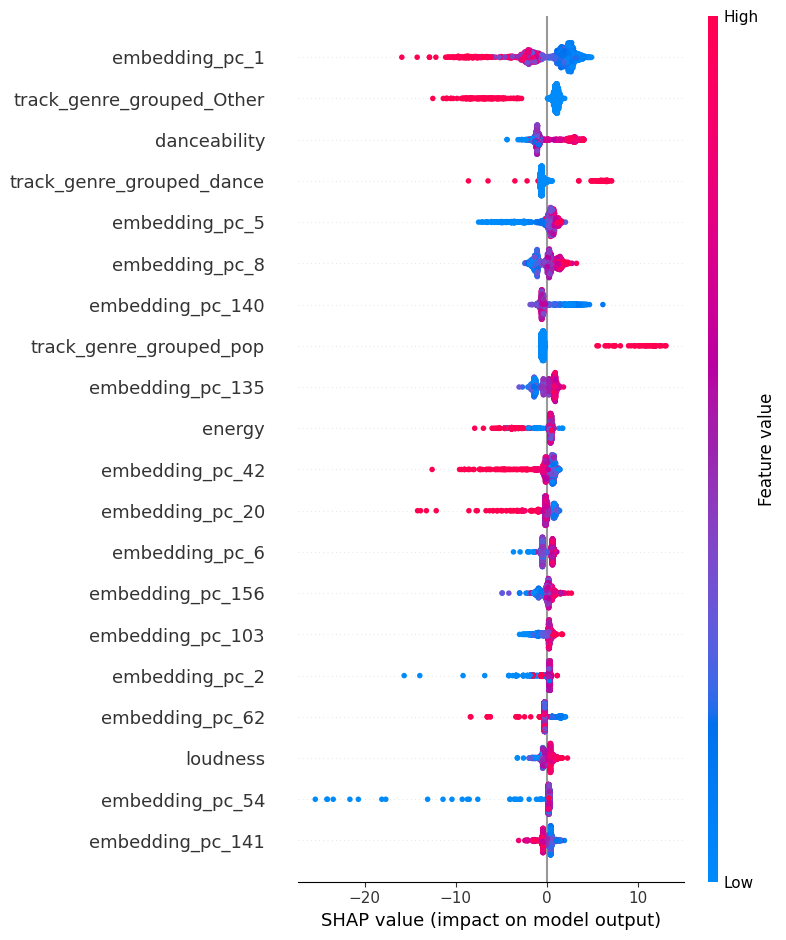

In [82]:
shap.summary_plot(
    shap_values,
    X_train_transformed,
    feature_names=feature_names,
    show=True
)


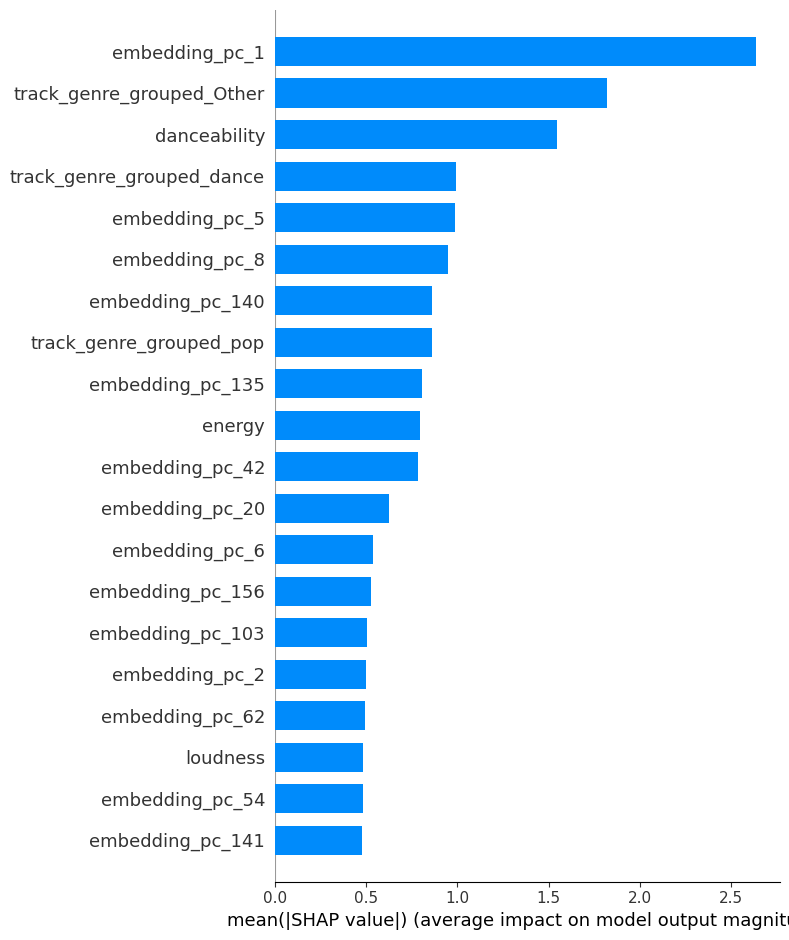

None


In [ ]:
shap.summary_plot(
    shap_values,
    X_train_transformed,
    feature_names=feature_names,
    plot_type="bar",
    show=True
)